In [1]:
import torch
import numpy as np
import os

#import gpt as g
import matplotlib.pyplot as plt

import time

import sys
sys.path.append("src/")

from qcd_ml.nn.lptc import v_LPTC
from qcd_ml.qcd.dirac import dirac_wilson_clover
#from qcd_ml.compat.gpt import lattice2ndarray, ndarray2lattice
from qcd_ml.util.solver import GMRES_torch
from qcd_ml.util.qcd.multigrid import ZPP_Multigrid
from qcd_ml.base.paths import v_evaluate_path, v_ng_evaluate_path, v_reverse_evaluate_path, PathBuffer
from qcd_ml.base.operations import v_spin_transform, v_ng_spin_transform

In [5]:
vec = torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.cdouble)

U = torch.tensor(np.load(os.path.join("test", "assets","1500.config.npy")))
w = dirac_wilson_clover(U, -0.58, 1.0)

In [7]:
def arnoldi_k(A, qprev, Hprev, k):
    innerproduct = lambda x,y: (x.conj() * y).sum()
    if hasattr(A, "__call__"):
        qk = A(qprev[k-1])
    else:
        qk = A @ qprev[k-1]

    for j in range(k):
        Hprev[j, k-1] = innerproduct(qprev[j], qk)
        qk = qk - Hprev[j, k-1] * qprev[j]
    Hprev[k, k-1] = innerproduct(qk, qk)**0.5
    qk /= Hprev[k, k-1]
    qprev[k] = qk
    return qprev, Hprev

def arnoldi(A, n, q0):
    if n < 1:
        raise ValueError("nothing to do")
    H = np.zeros((n+1, n), dtype=complex)
    # This is Q^T because the shape of the
    # vectors is not known.
    q = [q0] + [None]*n

    for k in range(1, n+1):
        q, H = arnoldi_k(A, q, H, k)

    return q, H

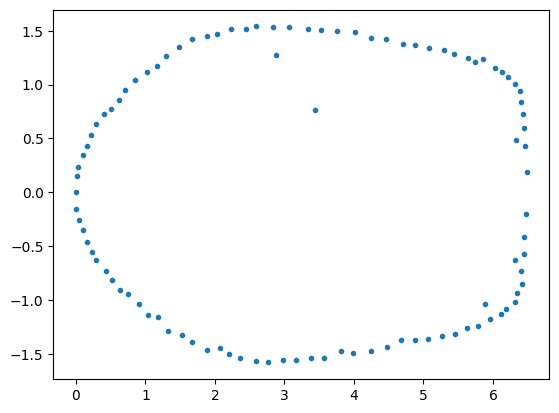

In [8]:
with torch.no_grad():
    q, H = arnoldi(w, 100, vec)

evals, evec = np.linalg.eig(H[:-1])
plt.plot(evals.real, evals.imag, ".")

In [12]:
orig_vecs = [torch.randn_like(vec) for _ in range(12)]



mg = ZPP_Multigrid.gen_from_fine_vectors(orig_vecs, [4, 4, 4, 4], lambda b, x0: GMRES_torch(w, b, x0, maxiter=300, eps=1e-3))


In [13]:
def coarse_operator_mg(mg: ZPP_Multigrid, op):
    def operator(vec):
        return mg.v_project(
            op(
                mg.v_prolong(vec))
        )
    return operator

In [14]:
with torch.no_grad():
    v_coarse = mg.v_project(vec)
    
    w = dirac_wilson_clover(U, -0.58, 1.0)
    w_coarse = coarse_operator_mg(mg, w)
    
    q, H = arnoldi(w_coarse, 385, v_coarse)

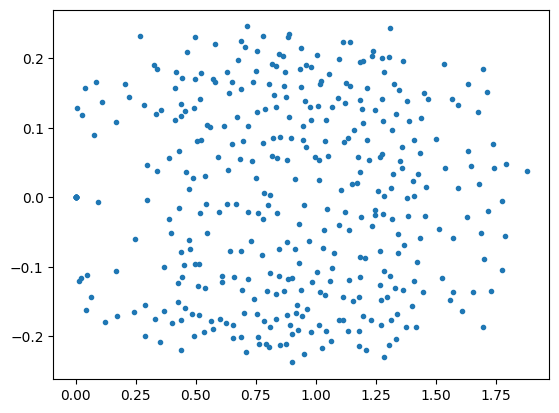

In [15]:
evals, evec = np.linalg.eig(H[:-1])
plt.plot(evals.real, evals.imag, ".")

In [16]:
mg.save("mg_setup_02.pt")

/home/knd35666/physics/ML/lattice_ML/reimplement_pytorch/qcd_ml_next/src/qcd_ml/util/qcd/multigrid.py:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  args = torch.load(fi

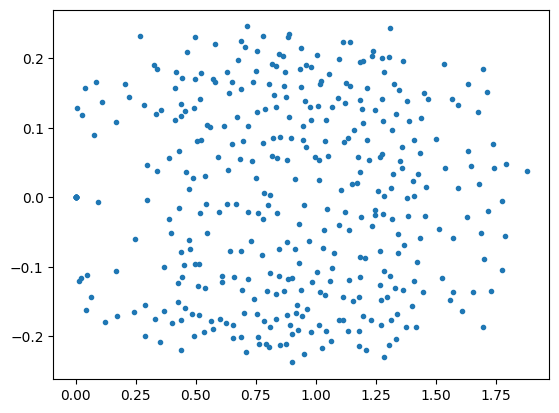

In [17]:


mg = ZPP_Multigrid.load("mg_setup_02.pt")

with torch.no_grad():
    v_coarse = mg.v_project(vec)
    
    w = dirac_wilson_clover(U, -0.58, 1.0)
    w_coarse = coarse_operator_mg(mg, w)
    
    q, H = arnoldi(w_coarse, 385, v_coarse)
    
evals, evec = np.linalg.eig(H[:-1])
plt.plot(evals.real, evals.imag, ".")